**MLP : метод обратного распространения ошибки**

два обрабатывающих слоя

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

##  загружаем данные 

In [2]:
# c1 = np.loadtxt('data/200_2b/points_1.txt')
# c2 = np.loadtxt('data/200_2b/points_2.txt')

In [3]:
# c1 = np.vstack([
#     np.loadtxt('data/399_4/points_b.txt'),
#     np.loadtxt('data/399_4/points_g.txt'),
#     np.loadtxt('data/399_4/points_r.txt')
# ])

# c2 = np.loadtxt('data/399_4/points_y.txt')

In [4]:
# c1 = np.loadtxt('data/6402_2/points_1.txt')
# c2 = np.loadtxt('data/6402_2/points_2.txt')

In [5]:
c1 = np.loadtxt('data/1998_2/points_b.txt')
c2 = np.loadtxt('data/1998_2/points_r.txt')

---

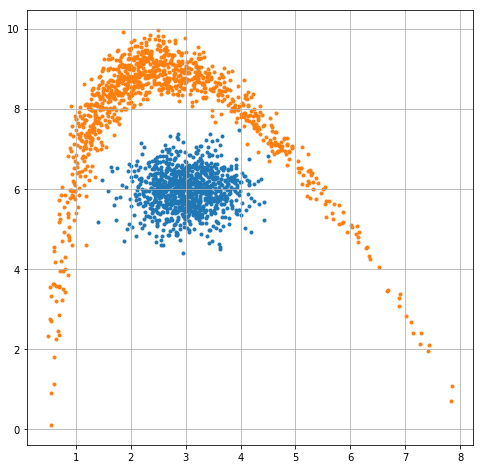

In [6]:
plt.gcf().set_size_inches(8,8)
plt.scatter(c1[:,0],c1[:,1],marker='.')
plt.scatter(c2[:,0],c2[:,1],marker='.')
plt.grid()
plt.show()

##  нормируем данные 

In [7]:
scaler = MinMaxScaler([0.0,1.0])

# scaler = MinMaxScaler([-1.0,1.0])


# собираем вместе
X = np.vstack([c1,c2])

# нормируем данные
scaler.fit(X)
X = scaler.transform(X)

X.shape, X.min(), X.max()

((1998, 2), 0.0, 1.0)

In [8]:
# метки классов

# [0,1] для выходной активации softmax
Y = np.array( [ 0, 1 ]*c1.shape[0] + 
              [ 1, 0 ]*c2.shape[0], 
            ).reshape( c1.shape[0] + c2.shape[0], 2 ) 
Y.shape

(1998, 2)

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# # метки классов
# y = [ [i]*data[i].shape[0] for i in range(len(data)) ]
# y = np.asarray(sum(y,[])).reshape(X.shape[0],1)
# y = OneHotEncoder(sparse=False,categories='auto').fit_transform(y)

In [9]:
# # [-1,1] для выходной активации sigmoid

# Y = np.array( [ -1.0, 1.0 ]*c1.shape[0] + 
#               [ 1.0, -1.0 ]*c2.shape[0], 
#             ).reshape( c1.shape[0] + c2.shape[0], 2 ) 
# Y.shape

##  делим данные 

In [10]:
r = int((time.time() % 1)*1e7) 

# тестовый
X, X_test, Y, Y_test = train_test_split( X, Y, test_size=0.33, random_state=r )

# контрольный
X, X_val, Y, Y_val = train_test_split( X, Y, test_size=0.5, random_state=r )

##  ф-ции слоёв

In [11]:
# ф-ция активации слоёв и её производная 

def softmax(z): 
    e = np.exp(z)
    return e/e.sum()

def softmax_drv(z): return 1.0 

def relu(z): return np.maximum( np.zeros(z.shape), z )
def relu_drv(z): return (z>0.0).astype(float)

def lrelu(z): return np.log(1.0+np.exp(z))
def lrelu_drv(z): return np.exp(z)/(np.exp(z)+1.0);

def sigm(z): return np.tanh(z)
def sigm_drv(z): return 1.0/(np.cosh(z)**2)

In [12]:
# z=np.random.rand(3)-0.5
# np.maximum( np.zeros(z.shape), z )
# (z>0.0).astype(float)

In [13]:
# функция потери

# средняя кросс-энтропия
def cross_entr(o,y):
    s = (o*y).sum(axis=1)
    return ( -np.log( s )).sum()/o.shape[0]

# средняя квадратичная ошибка
def msqe(o,y):
    e = (o-y).flatten() # ошибки примеров
    return np.asscalar( e.T.dot(e) / o.shape[0] ) 


##  параметры сети

In [14]:
# размер скрытого слоя
s_layer1 = 5
s_layer2 = 5

In [15]:
# act1 = relu
# act1_drv = relu_drv

# act2 = relu
# act2_drv = relu_drv

# act3 = softmax
# act3_drv = softmax_drv

# loss = cross_entr 

In [16]:
act1 = relu
act1_drv = relu_drv

act2 = relu
act2_drv = relu_drv

act3 = sigm
act3_drv = sigm_drv

loss = msqe

In [17]:
# act0 = sigm
# act0_drv = sigm_drv

# act1 = sigm
# act1_drv = sigm_drv

# loss = msqe

---

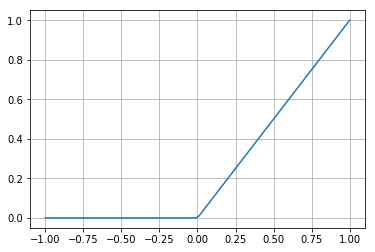

In [18]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act1(jj) )
plt.grid()
plt.show()

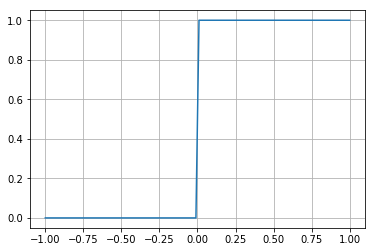

In [19]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act1_drv(jj) )
plt.grid()
plt.show()

##  инициализация весов и сдвигов

In [20]:
import time

# инициализация генератора псевдослучайных чисел
np.random.seed(seed= int((time.time() % 1)*1e7) )

In [21]:
# инициализация весов и сдвигов
W1 = np.random.normal( loc=0.0, scale=0.01, size = [X.shape[1], s_layer1] )  
S1 = np.zeros(s_layer1)

W2 = np.random.normal( loc=0.0, scale=0.01, size = [s_layer1, s_layer2 ] ) 
S2 = np.zeros(s_layer2)

W3 = np.random.normal( loc=0.0, scale=0.01, size = [s_layer2, Y.shape[1] ] ) 
S3 = np.zeros(Y.shape[1])


##  метод обратного распространения 

In [22]:
# выход
def run(x): 
    return act3( act2( act1( x.dot(W1) + S1 ).dot(W2) + S2 ).dot(W3) + S3 ) # выход сети

In [23]:
# прямой проход
def forward(x):
    L = [ x.dot(W1) + S1 ] # состояние (не активированное) скрытого слоя
    L.append( L[-1].dot(W2) + S2 ) # состояние (не активированное) скрытого слоя
    L.append( act1(L[-1]).dot(W3) + S3   ) # состояние (не активированное) выходного слоя
    return L

In [24]:
# обратный проход
def backward(L):
    O = act3(L[2]) # выход сети
    E = [ (O-Y)*act3_drv(L[2]) ] # ошибка выходного слоя
    E.insert(0, E[0].dot(W3.T)*act2_drv(L[1]) ) # ошибка скрытого слоя
    E.insert(0, E[0].dot(W2.T)*act1_drv(L[0]) ) # ошибка скрытого слоя
    return E

In [25]:
# L = forward(X) # прямой проход
# E = backward(L) # обратный проход

In [26]:
# градиент
def grad(L,E):
    GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O1 = act1(L[0]) # выход скрытого слоя
    GW.append( O1.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    O2 = act2(L[1]) # выход скрытого слоя
    GW.append( O2.T.dot(E[2]) ) # градиент по весам выходного слоя
    GS.append( E[2].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS

In [27]:
# L = forward(X) # прямой проход
# E = backward(L) # обратный проход
# G = grad(L,E)

In [28]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), 
                            gw[1].flatten(), 
                            gw[2].flatten(), 
                            
                            gs[0], 
                            gs[1], 
                            gs[2], 
                          ]) ).max()
    
    if (mw != 0):
        gw[0], gw[1], gw[2] = gw[0]/mw, gw[1]/mw, gw[2]/mw, 
        gs[0], gs[1], gs[2] = gs[0]/mw, gs[1]/mw, gs[2]/mw
            
    return gw,gs

## обучение сети

In [29]:
# метод градиентного спуска

# sa = 0.95 # изменение скорости обучения

a = 0.1 # скорость обучения
m = 0.001  # параметр момента
r = 0.0001  # параметр регуляризации

# максимальное число циклов обучения
MAX_ITER = 1800

MIN_ERROR = 0.15 # порог минимальной ошибки

err =[1e7,1e6,1e5] 

dW1,dW2,dW3 = 0.0, 0.0, 0.0
dS1,dS2,dS3 = 0.0, 0.0, 0.0


for i in range(MAX_ITER):
    
    O = run(X_val) 
    E = loss(O,Y_val)
    
    assert ~np.isnan(E)
        
    err.append(E) # история значений ф-ции потери
    if err[-1] < MIN_ERROR: # проверяем достижение порога
        print('порог ошибки достигнут')
        break
        
    if ( (err[-1]>err[-2]) and (err[-2]>err[-3]) and (err[-3]>err[-4]) ):
        print('мотоный рост ошибки')
        break

#     # если ошибка выросла
#     if(err[-1]>err[-2]): # то уменьшаем скорость обучения
#         a = max(1e-7,a*sa)
#     else: # иначе увеличиваем скорость обучения
#         a = min(1.0,a/sa)
            
    
    L = forward(X) # прямой проход
    E = backward(L) # обратный проход
    
    GW,GS = grad(L,E) # градиент
    GW,GS = grad_norm(GW,GS) # нормируем градиент
    
    # изменяем веса и сдвиги
    dW1 = a*( GW[0] + r*W1 ) + m*dW1
    dW2 = a*( GW[1] + r*W2 ) + m*dW2 
    dW3 = a*( GW[2] + r*W3 ) + m*dW3
    
    dS1 = a*GS[0] + m*dS1
    dS2 = a*GS[1] + m*dS2
    dS3 = a*GS[2] + m*dS3
    
    # изменяем веса и сдвиги
#     dW1,dW2,dW3 = a*GW[0],a*GW[1],a*GW[2]
#     dS1,dS2,dS3  = a*GS[0],a*GS[1],a*GS[2]
    
    W1 = W1 - dW1 
    W2 = W2 - dW2 
    W3 = W3 - dW3 

    S1 = S1 - dS1
    S2 = S2 - dS2
    S3 = S3 - dS3 

print('step:',i+1,'/',MAX_ITER)
print('error:',err[-1],'/',MIN_ERROR)

step: 1800 / 1800
error: 0.41224181720557257 / 0.15


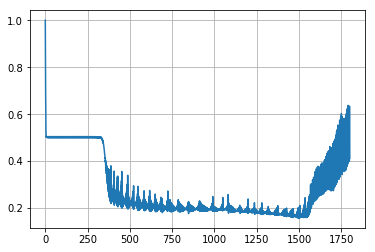

In [30]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[3:])
plt.grid()
plt.show()

##  результаты

In [31]:
O = run(X_test)
r=np.argmax(O,axis=1).astype(bool)

X1 = X_test[  r, : ]
X2 = X_test[ ~r, : ]

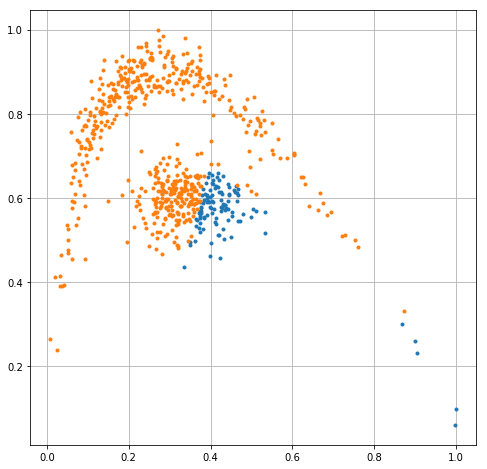

In [32]:
plt.gcf().set_size_inches(8, 8)
plt.plot(X1[:,0],X1[:,1],'.')
plt.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()